# Step One Photon Number Discrimination
* Determine the height thresholds for 2 level discrminator
* Obtain area histogram of traces
* Use area histogram to categorise photon number in traces

Output files:
List of n=1 traces
List of n=2 traces
Data file with:
    Height threshold
    Noise threshold
    n=1 integral center
    n=2 integral limits

In [1]:
from __future__ import division
import tqdm
import os
import sys
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')

import math
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import pickle
from multiprocess import Pool

import seaborn

import trace_param as tp
import heralded_pulses_analysis as hpa
import thres_poiss
import thres
import pulse_utils as pu
reload(pu)

<module 'pulse_utils' from '/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode/pulse_utils.pyc'>

In [3]:
# Imports CW traces
directories = ['/mnt/disk0/home/jianwei_leejw/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/240ns/']

results_directory = './'
filelist=[]
for directory_name in directories:
    subfilelist = np.array(glob.glob(directory_name + '*.trc'))
    filelist.extend(subfilelist)
filelist = np.sort(np.array(filelist))
print len(filelist)

33847


# Get Approximate Height Threshold
Estimate threshold height to discriminate between electrical noise and photodetection events.

Gets maximum height of pulses, histograms the heights. 

Fit the distributions to a model to find the minimum crossing point between the distributions.

The resolution of this distribution will not be optimal due to the presence of partial pulses at the edges.

In [4]:
sample_size = int(1*len(filelist)) # number of samples to obtain height threshold from

In [5]:
reload(tp)
# max_heights = np.array([hpa.max_height(f) for f in tqdm.tqdm(filelist[:sample_size])])
max_heights = np.array(Pool(24).map(hpa.max_height, tqdm.tqdm(filelist[:sample_size])))

100%|██████████| 33847/33847 [00:05<00:00, 6170.03it/s]


In [6]:
bins = 200

In [7]:
height_distribution = np.histogram(max_heights, bins)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


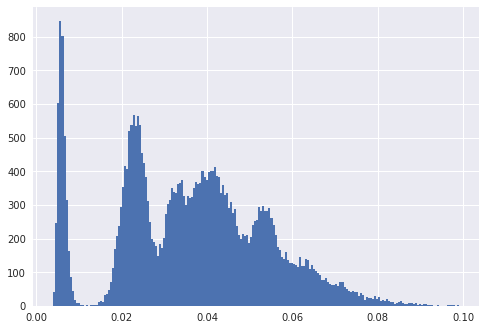

In [8]:
plt.figure()
plt.hist(max_heights,200);
plt.show()

In [9]:
frequencies ,binsv = thres.histogram(height_distribution)
binsv[np.where(frequencies==np.min(frequencies[(binsv>0.005)&(binsv<0.015)]))]

array([ 0.01133167,  0.01228275,  0.09312468,  0.09360022,  0.09455131,
        0.09502685,  0.09550239,  0.09597793,  0.09835563])

In [10]:
height_distribution = np.histogram(max_heights[max_heights < 0.03], bins)

In [11]:
reload(thres_poiss)
height_th_approx = thres_poiss.thresholds_N_unnormed(height_distribution, 
                                            min_peak_sep=0.01, 
                                            weighted=True)[0]
print height_th_approx

[ 0.00584809  0.02341959]
0.00962270901006


In [13]:
height_th_approx = 0.00962270901006

[ 0.00584809  0.02341959]
[[Model]]
    (Model(gaussian, prefix='g0_') + Model(gaussian, prefix='g1_'))
[[Variables]]
    A:              1.54471903 +/- 0.027176 (1.76%) (init= 2.79)
    n_bar:          1.23959039 +/- 0.027467 (2.22%) (init= 0.4)
    g0_sigma:       0.00078047 +/- 1.96e-05 (2.51%) (init= 0.002)
    sigma_p:        0.00297663 +/- 5.27e-05 (1.77%) (init= 0.002250791)
    g0_center:      0.00596897 +/- 2.66e-05 (0.45%) (init= 0.005848092)
    g1_center:      0.02336303 +/- 6.81e-05 (0.29%) (init= 0.02341959)
    g0_amplitude:   0.44720044 +/- 0.014538 (3.25%)  == 'A * exp(-n_bar)'
    g1_amplitude:   1.09751858 +/- 0.022960 (2.09%)  == 'A * (1-exp(-n_bar))'
    g1_sigma:       0.00297663 +/- 5.27e-05 (1.77%)  == 'sigma_p'
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma_p, g1_center)        =  0.303 
    C(g0_sigma, g0_center)       =  0.236 



<IPython.core.display.Javascript object>


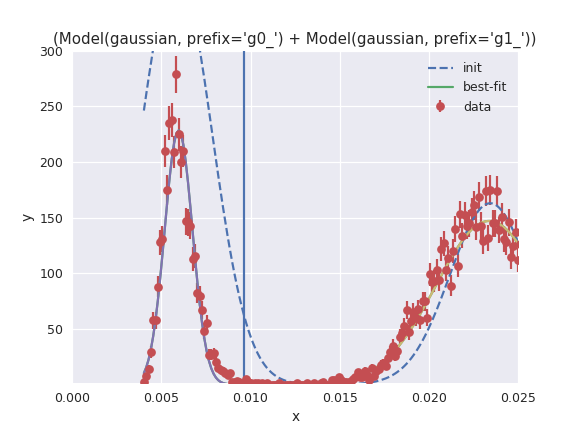

In [14]:
result_height_approx =  thres_poiss.gauss_fit_interp(height_distribution, 
                                  min_peak_sep=0.01,
                                  weighted=True)
print result_height_approx.fit_report()
frequencies ,bins = thres.histogram(height_distribution)
comps = result_height_approx.eval_components(x=bins)
%matplotlib notebook
plt.figure()
plt.title('Maximum Height Distribution (ignoring edges)\nSample size = {}'.format(sample_size))
result_height_approx.plot_fit()
plt.plot(bins,comps['g0_'])
plt.plot(bins,comps['g1_'])
plt.xlim(0,0.025)
plt.ylim(1,300)
plt.axvline(height_th_approx)
# plt.semilogy()
plt.show()

plt.figure()
plt.title('Maximum Height Distribution\nSample size = {}'.format(sample_size))
plt.bar(height_distribution[1][:-1],
        height_distribution[0], 
        width = np.diff(height_distribution[1])[0],
        align='center')
plt.axvline(height_th_approx, label='height_th_approx', linestyle='--')
plt.legend()
plt.show()

# Get Height Threshold (excluding partial pulses)
The maximum height of pulses at the edge of the acquisition window do not report the peak photodetection signal - they are obscured.

We use the approximate height obtained to initialise a two level discriminator.

The discriminator has 3 inputs:
* high_th: the level crossing that identifies the signal as a photodetection event
* low_th: the level crossing that turns the discriminator logic off
* offset: the number of data points that the discriminator window extends, in order to improve the signal to noise ratio

We use param_extr to calculate these values, 
(within discriminated windows, while ignoring partial traces)
* max height 
* rms 
* absolute area 

In [15]:
# Calculate offset value as a function of points
time_vector = pu.time_vector(filelist[0])
dt = np.diff(time_vector)[0]
offset = int(1700e-9/dt)
print offset

850


In [16]:
trace_parameters_approx = np.array(Pool(23).map(lambda f: hpa.param_extr(f,
                                   high_th = height_th_approx,
                                   low_th = 0,
                                   offset = offset),
                                  tqdm.tqdm(filelist[:sample_size])))

100%|██████████| 33847/33847 [00:14<00:00, 2341.00it/s]


In [17]:
max_heights_discriminated = trace_parameters_approx['height']

In [18]:
bins = 500
height_distribution_discriminated = np.histogram(max_heights_discriminated[max_heights_discriminated<0.03], bins)

In [19]:
frequencies ,binsv = thres.histogram(height_distribution_discriminated)
binsv[np.where(frequencies==np.min(frequencies[(binsv>0.0075)&(binsv<0.0125)]))]

array([ 0.00403888,  0.00898493,  0.00908906,  0.00919318,  0.00924525,
        0.00934937,  0.0094535 ,  0.00955763,  0.00966176,  0.00992208,
        0.00997414,  0.01007827,  0.01013033,  0.01018239,  0.01028652,
        0.01033858,  0.01039065,  0.01049478,  0.01054684,  0.01065097,
        0.01070303,  0.01075509,  0.01080716,  0.01085922,  0.01096335,
        0.01101541,  0.01106748,  0.01111954,  0.0111716 ,  0.01122367,
        0.01127573,  0.01132779,  0.01137986,  0.01143192,  0.01148399,
        0.01153605,  0.01158811,  0.01164018,  0.01169224,  0.0117443 ,
        0.01179637,  0.01184843,  0.0119005 ,  0.01195256,  0.01200462,
        0.01205669,  0.01210875,  0.01216081,  0.01221288,  0.01226494,
        0.012317  ,  0.01236907,  0.01242113,  0.0124732 ,  0.01252526,
        0.01257732,  0.01268145,  0.01273351,  0.01278558,  0.01283764,
        0.01288971,  0.01294177,  0.01299383,  0.0130459 ,  0.01309796,
        0.01320209,  0.01325415,  0.01330621,  0.01335828,  0.01

In [20]:
height_distribution_discriminated = np.histogram(max_heights_discriminated[max_heights_discriminated<0.03], bins)

In [21]:
reload(thres_poiss)

result_height =  thres_poiss.gauss_fit_interp(height_distribution_discriminated, 
                                  min_peak_sep=0.01,
                                  weighted=True)

height_th = thres_poiss.thresholds_N_unnormed(height_distribution_discriminated, 
                                            min_peak_sep=0.01, 
                                            weighted=True)
print result_height.fit_report()
height_th = height_th[0]
height_th

[ 0.00580904  0.02377102]
[ 0.00580904  0.02377102]
[[Model]]
    (Model(gaussian, prefix='g0_') + Model(gaussian, prefix='g1_'))
[[Variables]]
    A:              0.58139183 +/- 0.009318 (1.60%) (init= 1.29)
    n_bar:          1.23807340 +/- 0.025001 (2.02%) (init= 0.4)
    g0_sigma:       0.00075726 +/- 1.72e-05 (2.27%) (init= 0.002)
    sigma_p:        0.00292449 +/- 4.83e-05 (1.65%) (init= 0.002250791)
    g0_center:      0.00595210 +/- 2.34e-05 (0.39%) (init= 0.005809044)
    g1_center:      0.02336059 +/- 6.05e-05 (0.26%) (init= 0.02377102)
    g0_amplitude:   0.16857007 +/- 0.004990 (2.96%)  == 'A * exp(-n_bar)'
    g1_amplitude:   0.41282175 +/- 0.007869 (1.91%)  == 'A * (1-exp(-n_bar))'
    g1_sigma:       0.00292449 +/- 4.83e-05 (1.65%)  == 'sigma_p'
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma_p, g1_center)        =  0.274 
    C(g0_sigma, g0_center)       =  0.213 



0.0096096930880261219

In [22]:
# frequencies ,bins = thres.histogram(height_distribution_discriminated)
comps = result_height.eval_components(x=binsv)

<IPython.core.display.Javascript object>


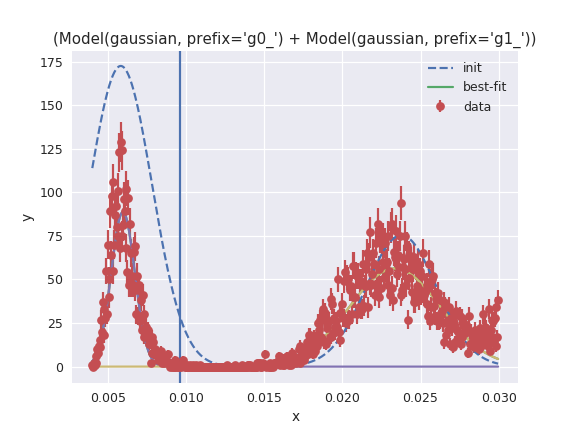

In [23]:
%matplotlib notebook
plt.figure()
plt.title('Maximum Height Distribution (ignoring edges)\nSample size = {}'.format(sample_size))
result_height.plot_fit()
plt.plot(binsv,comps['g0_'])
plt.plot(binsv,comps['g1_'])
# plt.xlim(0.006,0.025)
# plt.ylim(1,100)
plt.axvline(height_th)
# plt.semilogy()
plt.show()

In [24]:
height_th = 0.0096096930880261219

In [25]:
# t = 0.0079408483085594457 #threshold using likelihood
t = height_th #threshold using posterior
thres_bin = hpa.find_idx(bins,t)
noise = int(np.sum(comps['g0_'][thres_bin:]))
signal_lost = int(np.sum(comps['g1_'][:thres_bin]))
signal_total = int(np.sum(comps['g1_']))
print noise, signal_lost, signal_total

3223 0 7836


In [26]:
np.savetxt('max_heights_discriminated.dat',max_heights_discriminated)
np.savetxt('pnr_height.dat',thres.histogram(height_distribution_discriminated))
np.savetxt('g0_component.dat',comps['g0_'])
np.savetxt('g1_component.dat',comps['g1_'])
with open('pnr_height_readme.dat','w+') as fp:
    fp.write('height_th = {}\n samples = {}'.format(height_th,sample_size))
fp.close()

# Calculate trace parameters with height threshold (obtained excluding partial pulses)
* Computes trace parameters for ALL traces
* Speeds up tasks with multiprocessing

In [55]:
# Import/Set discriminator settings
# if os.path.isfile(results_directory + 'disc_settings.dat'):
[height_th, offset] = np.loadtxt(results_directory + 'disc_settings.dat')
offset = int(offset)

IOError: [Errno 2] No such file or directory: './disc_settings.dat'

In [27]:
# saves discriminator characteristics
np.savetxt(results_directory + 'disc_settings.dat', [height_th, offset],header='height_th\toffset')

In [28]:
print height_th, offset

0.00960969308803 850


In [29]:
reload(hpa)
tasks = tqdm.tqdm(filelist[:])
def param_extr_poolable(f):
    """poolable version of parameter extractor"""
    return hpa.param_extr(f,
                   high_th = height_th,
                   low_th = 0,
                   offset = offset)

  0%|          | 0/33847 [00:00<?, ?it/s]

In [30]:
# reload(hpa)
reload(pu)
if os.path.isfile(results_directory + 'trace_params.dat'):
    trace_parameters = np.genfromtxt(results_directory + 'trace_params.dat', names=True)
else:
    trace_parameters = np.array(Pool(23).map(param_extr_poolable, tasks))
# trace_parameters = np.array(Pool(23).map(param_extr_poolable, tasks))

100%|██████████| 33847/33847 [00:13<00:00, 2452.08it/s]


In [31]:
print trace_parameters.dtype.names
area = trace_parameters['area_win_abs']
numedges = trace_parameters['numedges']

('filename', 'numedges', 'area_win', 'area_win_abs', 'height', 'rms', 'bg_mv')


In [32]:
e1 = numedges==1
e2 = numedges==2
e3 = numedges==3
a1 = area[e1]
a2 = area[e2]
a3 = area[e3]
np.savetxt('AbsArea_1Edge.dat',a1)
np.savetxt('AbsArea_2Edge.dat',a2)
np.savetxt('AbsArea_3Edge.dat',a3)

<IPython.core.display.Javascript object>


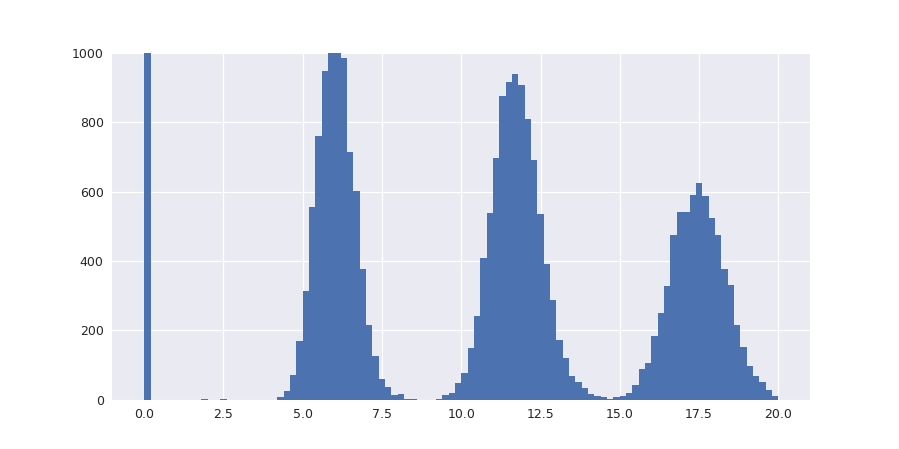

In [33]:
plt.figure(figsize=(10,5))
plt.hist(area,100,range=(0,20))
# plt.hist(area,100,range=(2.5,20),label='all',alpha=0.5)
# plt.hist(a1,100,range=(2.5,20),label='1edge',alpha=0.5);
# plt.hist(a2,100,range=(2.5,20),label='2edges');
# plt.hist(a3,100,range=(2.5,20),label='3edges');
plt.ylim(1,1000)
# plt.semilogy()
plt.show()

In [34]:
trace_parameters['filename'][0]

u'/mnt/disk0/home/jianwei_leejw/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/240ns/C2_double_240ns_00000.trc'

# Fit Area Distribution
* Select traces with number of edges = 1: we are only interested in traces occuring within the disrciminator window, traces which are overlapped.
* Threshold (th01) between n=0, n=1 determined by seeking the minimum between the two distributions.
* N >= 1 distributions fitted with Gaussian multiplied by Poisson coefficients
* N=1 distribution is selected to be within 2 sigmas of its distribution.
* N=2 distribution selected to be within th12 and th23

In [35]:
bins = 200
lims = (0,20)
area_distribution = np.histogram(area, bins) 

In [36]:
# Count n=1 traces
# frequencies ,binsv = thres.histogram(area_distribution)
# p1 = np.sum(f[(binsv>2.5)&(binsv<9.45)])/400000
# print 'p(n=1) =', p1

In [37]:
def nbar(frequencies,bins,height_th):
    """
    nbar estimate from n0 population.
    initially, plan was to get n0 from height distribution: -np.log((40000-9649)/40000)
    however, the nbar obtained from the n=1 population from the area distribution (with only 1 edge) 
    predicted an n=2 population from the area distribution (with both 1 and 2 edges)
    """
    n0 = np.sum(frequencies[bins<=height_th])
    n = np.sum(frequencies)
    print n0/n
    return -np.log(n0/n)
def poiss(k,nbar):
    return nbar**k*np.exp(-nbar)/math.factorial(k)

In [38]:
# use p(n=1) from the area distribution[numedges==1] to estimate nbar
print poiss(1,0.2525)
print poiss(2,0.2525)*400000

0.196156193742
9905.88778397


In [39]:
# %matplotlib notebook
# plt.figure()
# plt.hist(area[numedges==1],100,range=(1,20),alpha=0.2,normed=False,label='1 edge')
# plt.hist(area[(numedges==1)|(numedges==2)],100,range=(1,20),alpha=0.2,normed=False,label='1 or 2 edges')
# plt.hist(area[~((numedges==1)&(area<9.2))],100,range=(1,20),alpha=0.2,normed=False, label='less n=0,1')
# plt.ylim(1,200)
# plt.xlim(8,15)
# plt.legend()
# plt.show()

In [40]:
# print nbar(frequencies,bins,0.0097), poiss(2,0.253)*400000
# print -np.log((40000-9649)/40000)
# print poiss(1,0.253)

est peak pos = [  6.14635347  12.00002343  17.5610099   23.12199637  28.97566634]
est peak hts = [1546 1357  925  469  190]
th01 = 3
poissonian probs from n=1,2...= [0.27002610324903076, 0.27066903443850665, 0.1808756642965689, 0.09065316430431343, 0.036347603666175399]


<IPython.core.display.Javascript object>


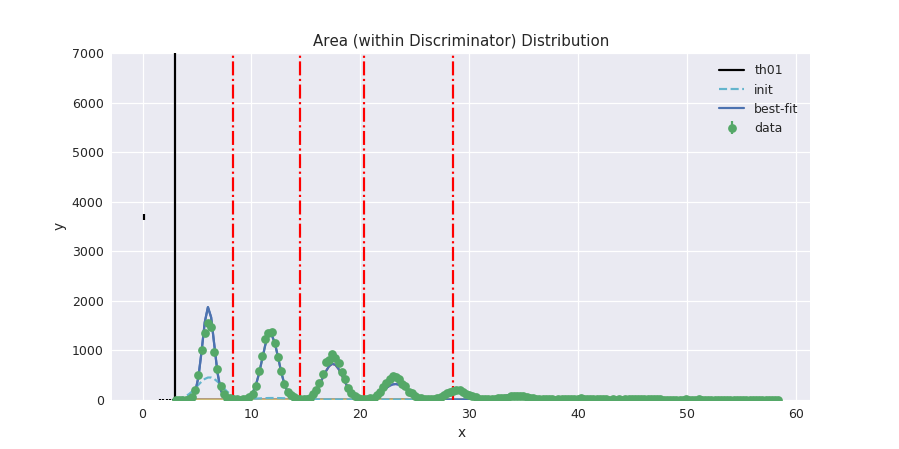

[[Model]]
    ((((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_')) + Model(gaussian, prefix='g4_')) + Model(gaussian, prefix='g5_'))
[[Variables]]
    n_bar:          2.00476199 (init= 0.2)
    A:              9339.00673 (init= 7730)
    Delta_E:        39.4785246 (init= 5)
    sigma_p:        0.53794171 (init= 1.125395)
    g1_center:      6.03163063 (init= 6.146353)
    g2_center:      11.7291887 (init= 12.00002)
    g3_center:      17.4780931 (init= 17.56101)
    g4_center:      23.2141184 (init= 23.122)
    g5_center:      34.3231157 (init= 28.97567)
    g1_amplitude:   2521.77559  == 'A * exp(-n_bar) * n_bar**1 / factorial(1)'
    g2_amplitude:   2527.77993  == 'A * exp(-n_bar) * n_bar**2 / factorial(2)'
    g3_amplitude:   1689.19904  == 'A * exp(-n_bar) * n_bar**3 / factorial(3)'
    g4_amplitude:   846.610511  == 'A * exp(-n_bar) * n_bar**4 / factorial(4)'
    g5_amplitude:   339.450515  == 'A * exp(-n_bar) * n_bar**5 / factorial(5

In [41]:
%matplotlib notebook
reload(thres)
result = thres.gauss_fit_poiss_ph_region(area_distribution,
                                         th01 = 3,
                                          min_peak_sep=5, 
                                          threshold=5e-2, 
                                          weighted=True,
                                          plot=True)
result.plot_fit()
plt.title('Area (within Discriminator) Distribution')
plt.ylim(1,7000)
# plt.xlim(2.35,22)
# plt.semilogy()
plt.show()

plt.figure()
plt.hist(area_prev[:50000],100,histtype='step',label='previous');
plt.hist(area_prev[-50000:],100,histtype='step');
plt.ylim(0,500)
plt.xlim(6,15)
plt.legend()
plt.show()

In [42]:
print result.best_values['g2_center']/result.best_values['g1_center']
print result.best_values['g3_center']/result.best_values['g1_center']

1.94461323228
2.8977393033


In [43]:
reload(thres)
thresholds_unnormed = thres.thresholds_N_unnormed(area_distribution,
                                          th01=3,
                                          min_peak_sep=5, 
                                          threshold=5e-2, 
                                          weighted=True,
                                          )
print thresholds_unnormed
ax = plt.gca(); map(lambda t: ax.axvline(t, linestyle='-.',color='red'),thresholds_unnormed); #plot thresholds in area distribution

est peak pos = [  6.14635347  12.00002343  17.5610099   23.12199637  28.97566634]
est peak hts = [1546 1357  925  469  190]
th01 = 3
poissonian probs from n=1,2...= [0.27002610324903076, 0.27066903443850665, 0.1808756642965689, 0.09065316430431343, 0.036347603666175399]
[8.3414797027861987, 14.487833167997081, 20.341503134864588, 28.536641088479097]


In [44]:
th01 = 3

In [45]:
frequencies ,bins = thres.histogram(area_distribution)
comps = result.eval_components(x=bins)

In [46]:
t = thresholds_unnormed[0] #threshold
thres_bin = hpa.find_idx(bins,t)
noise = int(np.sum(comps['g1_'][thres_bin:]))
signal_lost = int(np.sum(comps['g2_'][:thres_bin]))
signal_total = int(np.sum(comps['g2_']))
print noise, signal_lost, signal_total

0 0 8636


## Save PNR

In [47]:
np.savetxt('pnr_area_disc.dat',thres.histogram(area_distribution))
np.savetxt('g1_area_component.dat',comps['g1_'])
np.savetxt('g2_area_component.dat',comps['g2_'])
np.savetxt('g3_area_component.dat',comps['g3_'])
with open('pnr_area_readme.dat','w+') as fp:
    fp.write('a_th01 = {}\n a_th12 = {}\n a_th23 = {}'.format(th01,thresholds_unnormed[0],thresholds_unnormed[1]))
fp.close()

In [48]:
bins = 200
area_above_threshold = trace_parameters['area_win']
area_above_threshold_distribution = np.histogram(area_above_threshold, bins) 
frequencies, bins = thres.histogram(area_above_threshold_distribution)
np.savetxt('pnr_area_above_th.dat',thres.histogram(area_above_threshold_distribution))

# Photon Number Masks
* creates mask for photon numbers

In [49]:
mask_0ph = (area < th01)

In [50]:
# single photon mask: 
# within 2 std deviations of mean single-photon area to exclude outliers corresponding to more false positives 
mask_1ph = (area > result.best_values['g1_center']-2*result.best_values['g1_sigma'])&\
           (area < result.best_values['g1_center']+2*result.best_values['g1_sigma'])
# two photon mask:
# within thresholds corresponding to minimal overlap between n=1 and n=3 photons
mask_2ph = (area > thresholds_unnormed[0])&(area < thresholds_unnormed[1])

In [51]:
print sum(mask_2ph)

9042


# Save filelists and fit results

In [52]:
# saves filelist of n = 0, 1, 2 photons
hpa.append2file(results_directory + 'filelist_zero_photon.dat',"\n".join(filelist[mask_0ph]))
hpa.append2file(results_directory + 'filelist_single_photon.dat',"\n".join(filelist[mask_1ph]))
hpa.append2file(results_directory + 'filelist_two_photon.dat',"\n".join(filelist[mask_2ph]))

In [53]:
# saves fit results of area distribution
f = open(results_directory + 'area_distribution_lmfit_result.dat','wb')
pickle.dump(result,f)
f.close()

In [54]:
# saves thresholds(point of minimal overlap) between number distributions 
th_areas_from_min_overlap = np.array(np.insert(thresholds_unnormed,0,th01))
np.savetxt(results_directory+'th_areas_from_min_overlap.dat',th_areas_from_min_overlap,header='\t'.join(['th01,th12,th23']))

In [55]:
# saves whole filelist and trace parameters for future reference
hpa.append2file(results_directory + 'filelist.dat',"\n".join(filelist))
np.savetxt(results_directory + 'trace_params.dat',
           trace_parameters,
           header="\t".join(trace_parameters.dtype.names),
           fmt=('%s %d %.18e %.18e %.18e %.18e %.18e')
          )

In [56]:
# saves fit result of height distribution
g = open(results_directory + 'height_distribution_lmfit_result_height_th_{}.dat'.format(height_th),'wb')
pickle.dump(result_height,g)
g.close()

# Calculate RMS noise of n=0 traces

In [57]:
a = np.genfromtxt(results_directory + 'filelist_zero_photon.dat', delimiter='\n',dtype='string')

In [58]:
test = np.genfromtxt('trace_params.dat',
                    dtype=[('filename', 'U256'),
                           ('numedges', 'int8'),
                        ('area_win', 'float64'),
                        ('area_win_abs', 'float64'),
                       ('height', 'float64'),
                       ('rms', 'float64'),
                       ('bg_mv', 'float64')
                       ])

In [59]:
print test[0]

(u'/mnt/disk0/home/jianwei_leejw/data/20170405_TES5_SQ1_fit_accuracy_80mK_iBias_104uA_7.2GHZ_100kOhm/240ns/C2_double_240ns_00000.trc', 1,  16.3839557,  16.74736417,  0.04669663,  0.00914067,  0.)


In [60]:
rms = np.mean(trace_parameters['rms'][mask_0ph])
np.savetxt(results_directory + 'rms.dat', 
           [rms],
           header='rms')
print rms

0.00186830061546
